In [1]:
import pickle
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import sklearn.metrics

MODEL_FOLDER = os.environ.get('MODEL_FOLDER', 'trained_gan')
DATA_FOLDER = os.environ.get('DATA_FOLDER')
PLOTS_FOLDER = os.environ.get('PLOTS_FOLDER')



def load_artifact(model_name, obj_name, group_name='data'):
    model_artifact_path = DATA_FOLDER + '/' + model_name + '/' + group_name
    with open(model_artifact_path + '/' + obj_name + '.pkl', "rb") as f:
        return pickle.load(f)


def load_artifacts(model_name, group_name='data'):
    model_artifact_path = DATA_FOLDER + '/' + model_name + '/' + group_name
    files = os.listdir(model_artifact_path)
    a = []
    for fname in files:
        with open(os.path.join(model_artifact_path, fname), "rb") as f:
            a.append(pickle.load(f))
    return a


In [2]:
!pip install sklearn

In [3]:
sample_name = 'lat2_2.l2_n3_v2'
metrics_dfs = load_artifacts(sample_name, 'metrics_dfs')
metrics_df = pd.concat(metrics_dfs)

In [24]:

def calc_correlation_function(metrics_df):
    latent_dim = metrics_df['latent_dim'].max()

    dim_idx_cols = [f'dim_{i}_idx' for i in range(latent_dim)]
    dim_val_cols = [f'dim_{i}_value' for i in range(latent_dim)]
    
    
    metrics = ['performance']

    grid_val_agg = metrics_df.groupby(dim_idx_cols)[dim_val_cols].min()
    metrics_df_agg = metrics_df.groupby(dim_idx_cols)[metrics].mean()
    design_idx_agg = metrics_df.groupby(dim_idx_cols)['design_idx'].apply(list)

    df = pd.concat([grid_val_agg, metrics_df_agg, design_idx_agg], axis=1).reset_index()
    w_valid = (df['performance'] > -30000) & (df['performance'] < 30000) & ~df['performance'].isnull()
    df_v = df[w_valid].copy()
    
    
    
    dist = sklearn.metrics.pairwise_distances(df_v[dim_val_cols])
#     dist = sklearn.metrics.pairwise_distances(df_v[dim_val_cols], metric='manhattan')

    perf = df_v['performance'].values
    perf = perf - perf.mean()
    perf = perf / perf.std()

    l = []
    for d in np.arange(0.0,dist.max(),0.1):
        xidx, yidx = np.where((dist >= d) & (dist <= d+0.1))
        w = xidx > yidx
        xidx = xidx[w]
        yidx = yidx[w]
        cor = np.corrcoef(perf[xidx], perf[yidx])[0,1]
        l.append({'distance': d, 'corr': cor})
    return pd.DataFrame(l)


In [25]:
dfc1 = calc_correlation_function(metrics_df)

In [26]:
sample_name = 'lat4.l10_n50'
metrics2_dfs = load_artifacts(sample_name, 'metrics_dfs')
metrics2_df = pd.concat(metrics2_dfs)

In [27]:
dfc2 = calc_correlation_function(metrics2_df)

/home/local/MPIB-BERLIN/brinkmann/repros/airfoil-opt-gan/.venv/lib/python3.6/site-packages/numpy/lib/function_base.py:390: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/local/MPIB-BERLIN/brinkmann/repros/airfoil-opt-gan/.venv/lib/python3.6/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/local/MPIB-BERLIN/brinkmann/repros/airfoil-opt-gan/.venv/lib/python3.6/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/home/local/MPIB-BERLIN/brinkmann/repros/airfoil-opt-gan/.venv/lib/python3.6/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/local/MPIB-BERLIN/brinkmann/repros/airfoil-opt-gan/.venv/lib/python3.6/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply

In [28]:
# %matplotlib notebook
from scipy.interpolate import RectBivariateSpline
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import random
import numpy as np
import matplotlib.pyplot as plt


L = 100
w_min = 3
w_max = 7
R = 100
p = 0.5
# bounds = [[0,L], [0,L]]

def gen_perlin(L, w_min, w_max, persistence):
    land = np.zeros((L, L))
    for w in range(w_min, w_max + 1):
        rand = np.random.uniform(size=(2**w, 2**w))
        net_points = np.linspace(0, L, 2**w)
        f = RectBivariateSpline(x=net_points, y=net_points, z=rand, kx=3, ky=3)
        land += f(np.arange(L),np.arange(L)) * persistence**w
    return land


def gen_gauss(L, R):
    x1, x2 = np.mgrid[0:L, 0:L]
    X = np.empty(x1.shape + (2,))
    X[:, :, 0] = x1; X[:, :, 1] = x2
    mean = np.random.uniform(0, L, size=2)
        
    rv = multivariate_normal(mean, [[R, 0], [0, R]])
    return rv.pdf(X)


def gen_perlin_gauss_mixture(L, R, w_min, w_max, persistence, mix_factor, seed):
    np.random.seed(seed)
    land_perlin = gen_perlin(L, w_min, w_max, persistence)
    land_gauss = gen_gauss(L, R)
    merged = land_perlin + land_gauss * mix_factor
    merged_norm = merged / merged.max() * 100
    return merged_norm


def land_function(landscape):
    def f(X):
        _X = X.astype(int)
        return landscape[[_X[:,0], _X[:,1]]]
    return f

def plot_landscape3d(land):
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111, projection='3d')
    x1, x2 = np.mgrid[0:L, 0:L]
    ax.plot_surface(X=x1, Y=x2, Z=merged_norm, cmap=cm.coolwarm)

def plot_landscape(land):
    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.contourf(np.arange(land.shape[0]), np.arange(land.shape[0]), land,100)
    plt.show()

merged_norm = gen_perlin_gauss_mixture(L, R, w_min, w_max, persistence=p, mix_factor=0, seed=2)
merged_norm.shape

(100, 100)

In [13]:
def make_perlin_df(w_min, w_max, seed=1):
    merged_norm = gen_perlin_gauss_mixture(L, R, w_min, w_max, persistence=p, mix_factor=0, seed=seed)
    df = pd.DataFrame(merged_norm, index=np.arange(L), columns=np.arange(L))
    df = df.stack().reset_index()

    df.columns = ['dim_0_idx', 'dim_1_idx', 'performance']
    mapper = pd.Series(np.linspace(0,1, L), index=np.arange(L))

    df['dim_0_value'] = df['dim_0_idx'].map(mapper)
    df['dim_1_value'] = df['dim_1_idx'].map(mapper)

    df['latent_dim'] = 2
    df['design_idx'] = np.arange(len(df))
    return df, merged_norm

In [10]:
df3, merged_norm3 = make_perlin_df(3, 7)
df4, merged_norm4 = make_perlin_df(2, 7)
df5, merged_norm5 = make_perlin_df(3, 3)

dfc3 = calc_correlation_function(df3)
dfc4 = calc_correlation_function(df4)
dfc5 = calc_correlation_function(df5)

In [11]:
dfc1['function'] = '2d Airfoils'
dfc2['function'] = '4d Airfoils'
dfc3['function'] = 'Perlin 3-7'
dfc4['function'] = 'Perlin 2-7'
dfc5['function'] = 'Perlin 2-2'


dfc = pd.concat([dfc1, dfc2, dfc3, dfc4, dfc5])

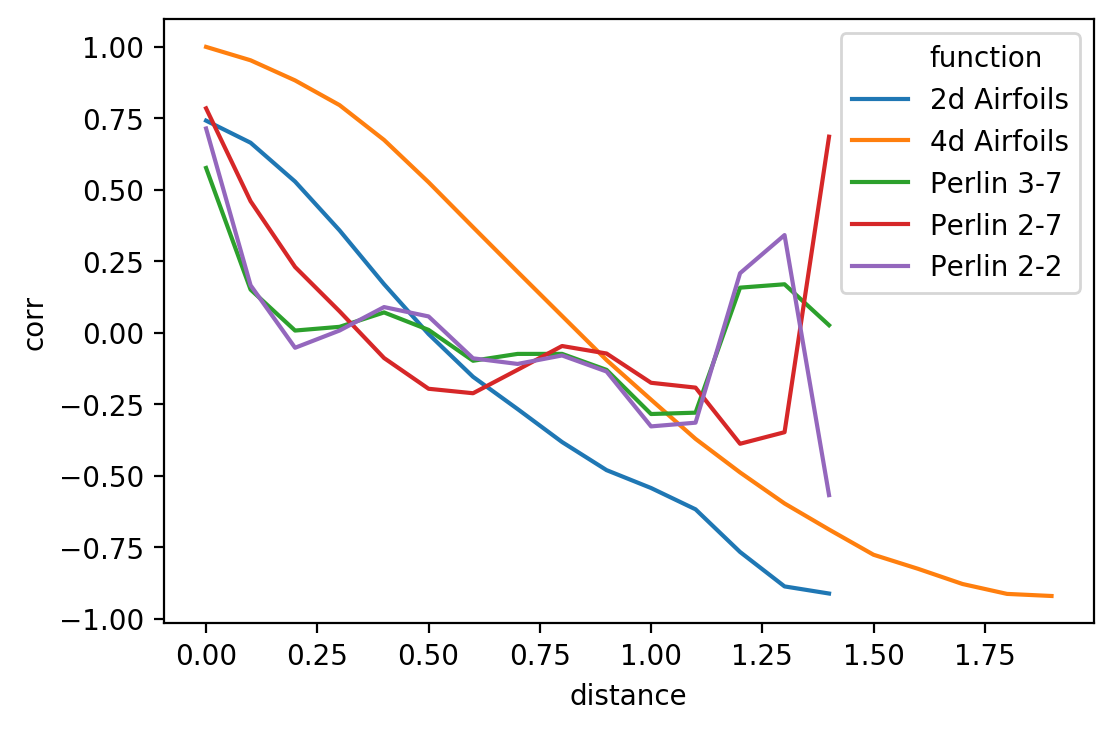

In [12]:
plt.figure(figsize=(6,4), dpi=200)
sns.lineplot(data=dfc, x='distance', y='corr', hue='function')

In [35]:
l = []
for s in range(50):
    df, merged_norm = make_perlin_df(3, 3, seed=s)
    dfc = calc_correlation_function(df)
    l.append(dfc)


In [36]:
dfa = pd.concat(l, axis=0)


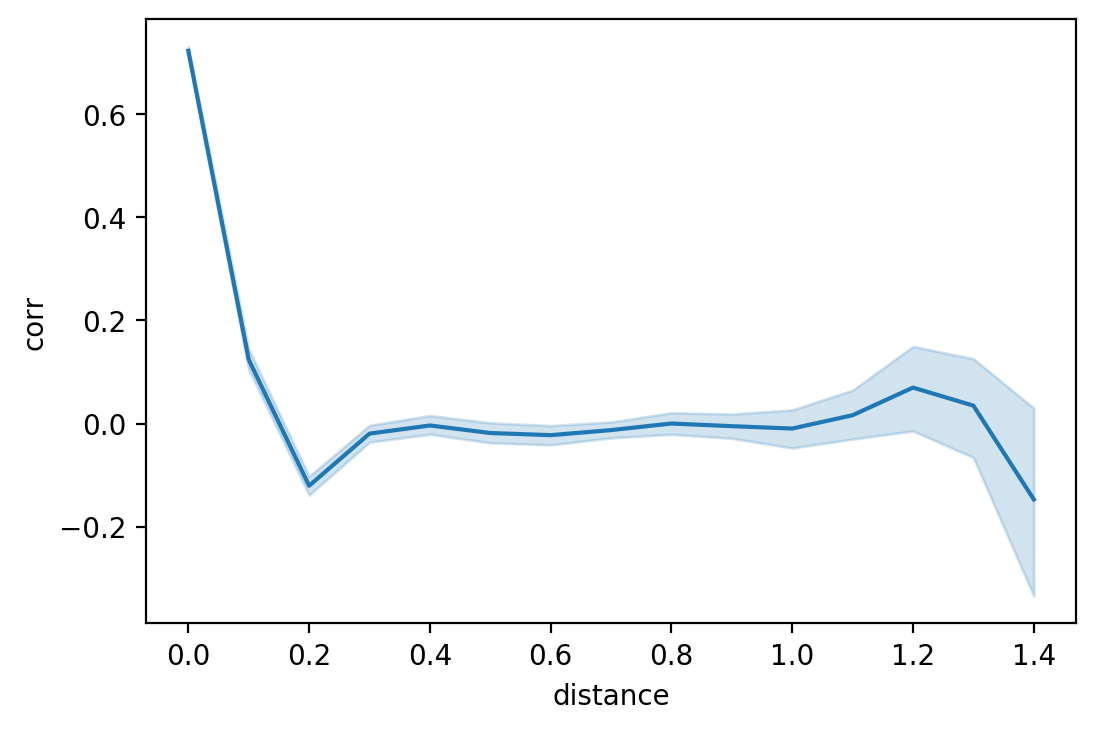

In [37]:
plt.figure(figsize=(6,4), dpi=200)
sns.lineplot(data=dfa, x='distance', y='corr')

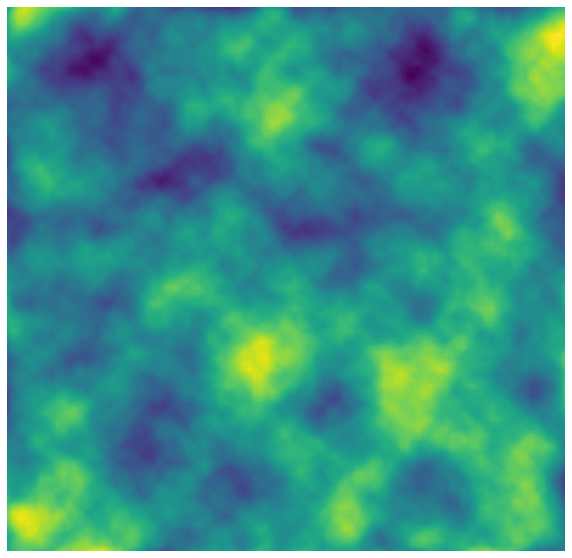

In [86]:
plot_landscape(-merged_norm3)

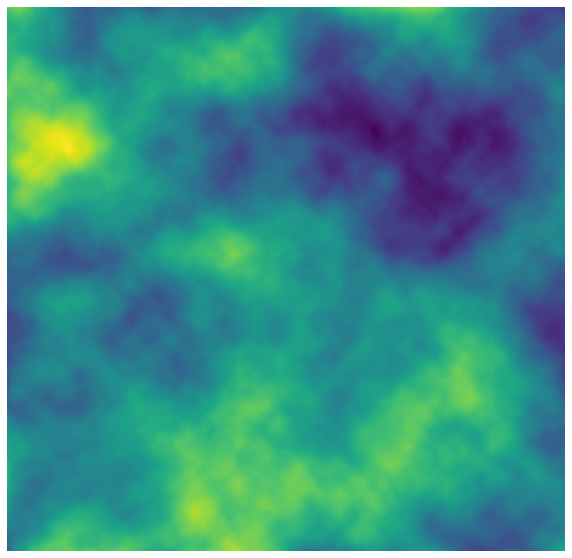

In [87]:
plot_landscape(-merged_norm4)

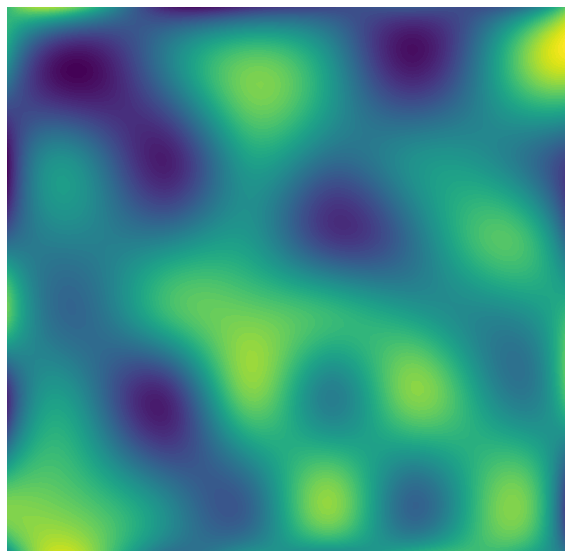

In [88]:
plot_landscape(-merged_norm5)